# Enhance!

A deep neural net model for de-noising blurry characters.

## Imports & Setup


In [29]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary

# Device to translate tensors to:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)

# Batch size (depends on available memory - adjust as needed)
batch_size = 64

## Data Loading


In [30]:
# Hyperparameters:
num_epochs = 10

learning_rate = 0.001

# Transforms
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Datasets
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

# Data-loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

## Model Definition


### Model 1 - Linear Layers (MLP)


In [31]:
# Linear-Linear-Tanh Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),  # Compressed representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


mlp_model = Autoencoder().to(device)

In [32]:
# Use torchinfo summary to get model summary
summary(mlp_model, input_size=(batch_size, 28 * 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [64, 784]                 --
├─Sequential: 1-1                        [64, 12]                  --
│    └─Linear: 2-1                       [64, 128]                 100,480
│    └─ReLU: 2-2                         [64, 128]                 --
│    └─Linear: 2-3                       [64, 64]                  8,256
│    └─ReLU: 2-4                         [64, 64]                  --
│    └─Linear: 2-5                       [64, 12]                  780
├─Sequential: 1-2                        [64, 784]                 --
│    └─Linear: 2-6                       [64, 64]                  832
│    └─ReLU: 2-7                         [64, 64]                  --
│    └─Linear: 2-8                       [64, 128]                 8,320
│    └─ReLU: 2-9                         [64, 128]                 --
│    └─Linear: 2-10                      [64, 784]                 101,1

### Model 2 - Convolutional Layers (CNN)


In [33]:
# # Conv-ConvTranspose Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=7)  # Compressed representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Reshape input to (Batch_size, Channels, Height, Width)
        x = self.encoder(x)
        x = self.decoder(x)
        return x.view(x.size(0), -1)  # Reshape back to (Batch_size, 784)


cnn_model = Autoencoder().to(device)

In [34]:
# Use torchinfo summary to get model summary
summary(cnn_model, input_size=(batch_size, 28 * 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [64, 784]                 --
├─Sequential: 1-1                        [64, 64, 1, 1]            --
│    └─Conv2d: 2-1                       [64, 16, 14, 14]          160
│    └─ReLU: 2-2                         [64, 16, 14, 14]          --
│    └─Conv2d: 2-3                       [64, 32, 7, 7]            4,640
│    └─ReLU: 2-4                         [64, 32, 7, 7]            --
│    └─Conv2d: 2-5                       [64, 64, 1, 1]            100,416
├─Sequential: 1-2                        [64, 1, 28, 28]           --
│    └─ConvTranspose2d: 2-6              [64, 32, 7, 7]            100,384
│    └─ReLU: 2-7                         [64, 32, 7, 7]            --
│    └─ConvTranspose2d: 2-8              [64, 16, 14, 14]          4,624
│    └─ReLU: 2-9                         [64, 16, 14, 14]          --
│    └─ConvTranspose2d: 2-10             [64, 1, 28, 28]           1

In [35]:
# learning rate for optimizers
learning_rate = 0.001

In [36]:
# Instantiate models and optimizers
models = {
    "mlp_model": mlp_model, 
    "mlp_model_optimizer": torch.optim.Adam(
        mlp_model.parameters(), lr=learning_rate
    ),
    "cnn_model": cnn_model,
    "cnn_model_optimizer": torch.optim.Adam(
        cnn_model.parameters(), lr=learning_rate
    )
}

## Training Loop


### Noising Function


In [37]:
# Adding noise to the dataset
def add_noise(img):
    noise = torch.randn(img.size()).to(device) * 0.2
    noisy_img = img + noise
    return noisy_img

### Loss Function


In [38]:
criterion = nn.SmoothL1Loss()

### Training


Epoch [1/10], Loss: 0.0466
mlp_model Validation Loss: 0.0472
Epoch [2/10], Loss: 0.0423
mlp_model Validation Loss: 0.0398
Epoch [3/10], Loss: 0.0417
mlp_model Validation Loss: 0.0369
Epoch [4/10], Loss: 0.0321
mlp_model Validation Loss: 0.0352
Epoch [5/10], Loss: 0.0369
mlp_model Validation Loss: 0.0345
Epoch [6/10], Loss: 0.0338
mlp_model Validation Loss: 0.0336
Epoch [7/10], Loss: 0.0371
mlp_model Validation Loss: 0.0325
Epoch [8/10], Loss: 0.0280
mlp_model Validation Loss: 0.0319
Epoch [9/10], Loss: 0.0375
mlp_model Validation Loss: 0.0313
Epoch [10/10], Loss: 0.0289
mlp_model Validation Loss: 0.0308


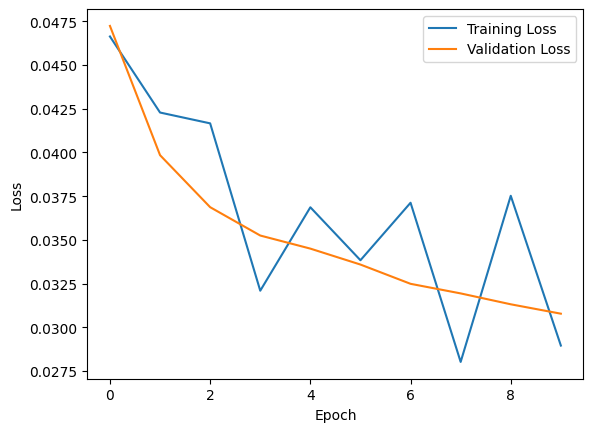

Epoch [1/10], Loss: 0.0151
cnn_model Validation Loss: 0.0147
Epoch [2/10], Loss: 0.0089
cnn_model Validation Loss: 0.0094
Epoch [3/10], Loss: 0.0077
cnn_model Validation Loss: 0.0079
Epoch [4/10], Loss: 0.0071
cnn_model Validation Loss: 0.0069
Epoch [5/10], Loss: 0.0062
cnn_model Validation Loss: 0.0064
Epoch [6/10], Loss: 0.0048
cnn_model Validation Loss: 0.0063
Epoch [7/10], Loss: 0.0061
cnn_model Validation Loss: 0.0059
Epoch [8/10], Loss: 0.0054
cnn_model Validation Loss: 0.0058
Epoch [9/10], Loss: 0.0062
cnn_model Validation Loss: 0.0057
Epoch [10/10], Loss: 0.0053
cnn_model Validation Loss: 0.0055


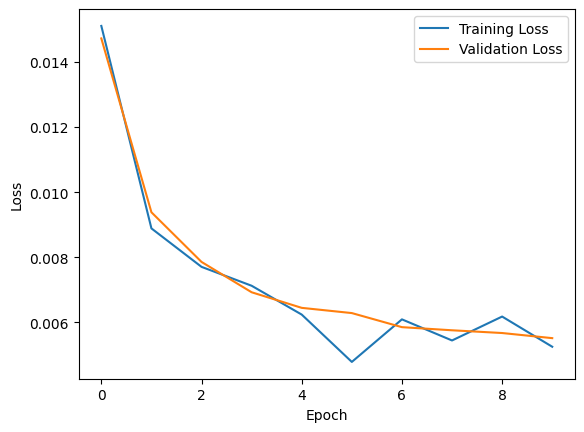

In [39]:
model_names = ["mlp_model", "cnn_model"]
num_epochs = 10

for model_name in model_names:

    model = models[model_name]
    optimizer = models[f"{model_name}_optimizer"]

    epoch_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            noisy_img = add_noise(img)

            # Forward pass
            outputs = model(noisy_img)
            loss = criterion(outputs, img)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_losses.append(loss.item())
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

        # Calculate validation loss
        validation_loss = 0.0
        with torch.no_grad():
            for data in test_loader:
                img, _ = data
                img = img.view(img.size(0), -1).to(device)
                noisy_img = add_noise(img)
                outputs = model(noisy_img)
                loss = criterion(outputs, img)
                validation_loss += loss.item()

        validation_loss /= len(test_loader)
        validation_losses.append(validation_loss)
        print(f"{model_name} Validation Loss: {validation_loss:.4f}")

    plt.figure()
    plt.plot(epoch_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Testing Loop


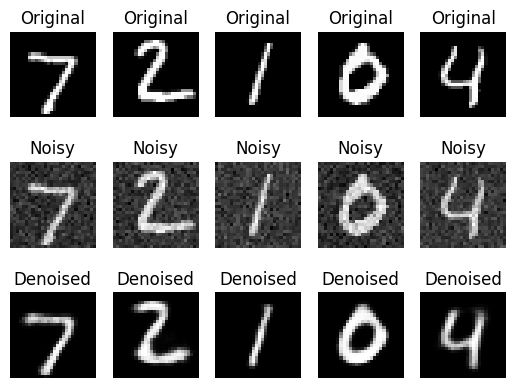

mlp_model Test Loss: 0.0002


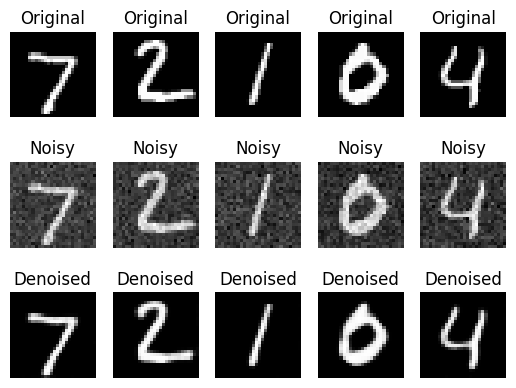

cnn_model Test Loss: 0.0000


In [40]:
for model_name in model_names:
    model = models[model_name]

    test_loss = 0.0

    model.eval()
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            noisy_img = add_noise(img)
            outputs = model(noisy_img)

            loss = criterion(outputs, img)
            test_loss += loss.item()

            # Visualize the first 5 images
            for i in range(5):
                plt.subplot(3, 5, i + 1)
                plt.imshow(img[i].cpu().reshape(28, 28), cmap="gray")
                plt.title("Original")
                plt.axis("off")

                plt.subplot(3, 5, i + 6)
                plt.imshow(noisy_img[i].cpu().reshape(28, 28), cmap="gray")
                plt.title("Noisy")
                plt.axis("off")

                plt.subplot(3, 5, i + 11)
                plt.imshow(outputs[i].cpu().reshape(28, 28), cmap="gray")
                plt.title("Denoised")
                plt.axis("off")
            plt.show()
            break

        test_loss /= len(test_loader)   
        print(f"{model_name} Test Loss: {test_loss:.4f}")

## Experiment: Batch normalization

Epoch [1/10], Loss: 0.0909
bn_model Validation Loss: 0.0294
Epoch [2/10], Loss: 0.0208
bn_model Validation Loss: 0.0146
Epoch [3/10], Loss: 0.0130
bn_model Validation Loss: 0.0108
Epoch [4/10], Loss: 0.0103
bn_model Validation Loss: 0.0091
Epoch [5/10], Loss: 0.0090
bn_model Validation Loss: 0.0083
Epoch [6/10], Loss: 0.0082
bn_model Validation Loss: 0.0077
Epoch [7/10], Loss: 0.0077
bn_model Validation Loss: 0.0073
Epoch [8/10], Loss: 0.0073
bn_model Validation Loss: 0.0070
Epoch [9/10], Loss: 0.0070
bn_model Validation Loss: 0.0067
Epoch [10/10], Loss: 0.0068
bn_model Validation Loss: 0.0066


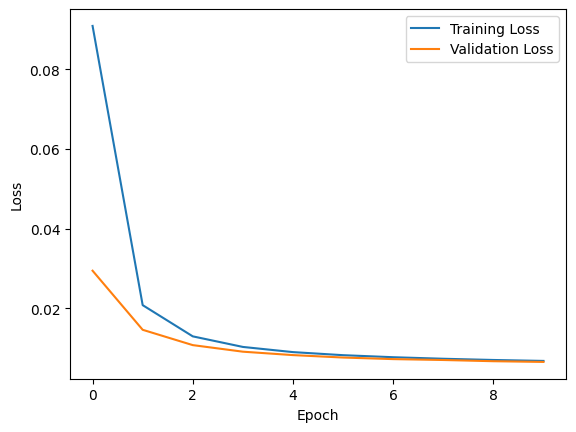

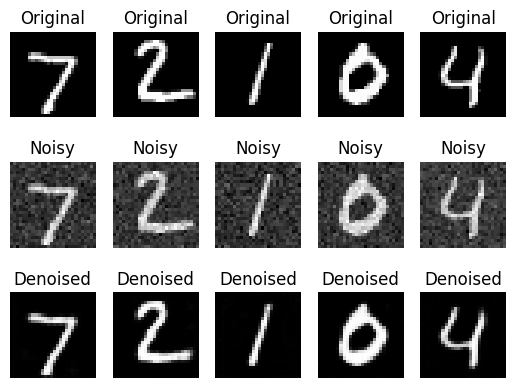

bn_model Test Loss: 0.0000


In [41]:
# # Conv-ConvTranspose Autoencoder
class AutoencoderBN(nn.Module):
    def __init__(self):
        super(AutoencoderBN, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=7)  # Compressed representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Reshape input to (Batch_size, Channels, Height, Width)
        x = self.encoder(x)
        x = self.decoder(x)
        return x.view(x.size(0), -1)  # Reshape back to (Batch_size, 784)


bn_model = AutoencoderBN().to(device)

# Use torchinfo summary to get model summary
summary(bn_model, input_size=(batch_size, 28 * 28), device=device)

# learning rate for optimizers
learning_rate = 0.0001  # Lower learning rate
num_epochs = 10

optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)

epoch_losses = []
validation_losses = []

for epoch in range(num_epochs):
    bn_model.train()
    total_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        noisy_img = add_noise(img)
        # Forward pass
        outputs = bn_model(noisy_img)
        loss = criterion(outputs, img)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_epoch_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

    # Calculate validation loss
    bn_model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            noisy_img = add_noise(img)
            outputs = bn_model(noisy_img)
            loss = criterion(outputs, img)
            validation_loss += loss.item()

    validation_loss /= len(test_loader)
    validation_losses.append(validation_loss)
    print(f"bn_model Validation Loss: {validation_loss:.4f}")

plt.figure()
plt.plot(epoch_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss = 0.0

bn_model.eval()
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        noisy_img = add_noise(img)
        outputs = bn_model(noisy_img)

        loss = criterion(outputs, img)
        test_loss += loss.item()

        # Visualize the first 5 images
        for i in range(5):
            plt.subplot(3, 5, i + 1)
            plt.imshow(img[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Original")
            plt.axis("off")

            plt.subplot(3, 5, i + 6)
            plt.imshow(noisy_img[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Noisy")
            plt.axis("off")

            plt.subplot(3, 5, i + 11)
            plt.imshow(outputs[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Denoised")
            plt.axis("off")
        plt.show()
        break

    test_loss /= len(test_loader)   
    print(f"bn_model Test Loss: {test_loss:.4f}")